In [1]:
from src.data.pipelines import fcn_pipeline
from src.models import fcn

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

import src.data.datasets.deep_globe_2018

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 1
SPLIT_TRAIN = '750:800'
SPLIT_VALID = '10:20'
SPLIT_TEST = '750:800'

CHECKPOINT_DIR = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'fcn_32s')

In [3]:
(train, valid, test) = fcn_pipeline.getFCNPipeline(
    SPLIT_TRAIN,
    SPLIT_VALID,
    SPLIT_TEST,
    BATCH_SIZE,
    IMAGE_SIZE
)

2024-01-31 19:15:29.695140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 19:15:29.730943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 19:15:29.731210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
latest = tf.train.latest_checkpoint(CHECKPOINT_DIR)
fcn_16s = fcn.get_fcn_16s(latest)

In [5]:
fcn_16s.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [9]:
def display(display_list):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

In [6]:
def one_hot_to_rgb(one_hot_map):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    one_hot_map = tf.cast(one_hot_map, tf.int32)
    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

1/1 [==============================] - 0s 167ms/step
3


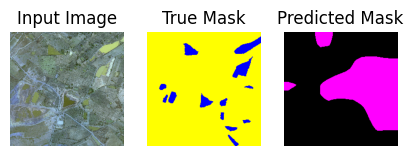

1/1 [==============================] - 0s 90ms/step
3


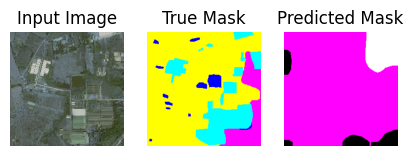

1/1 [==============================] - 0s 69ms/step
3


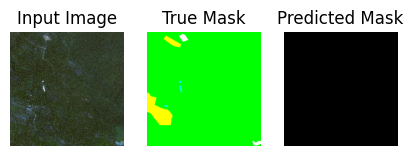

1/1 [==============================] - 0s 91ms/step
3


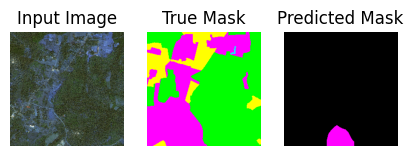

1/1 [==============================] - 0s 25ms/step
3


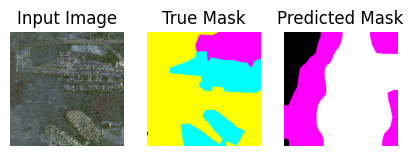

In [10]:
for i, m in train.skip(0).take(5):
    y = fcn_16s.predict(i)
    y_one_hot = tf.one_hot(tf.argmax(y, axis = 3), depth = 7)
    mask_gt = one_hot_to_rgb(m)
    mask_pred = one_hot_to_rgb(y_one_hot)
    display([i, mask_gt, mask_pred])